# Creacion e Insercion de los datos recopilados en '1_scrapping_de_datos.ipynb'.

In [1]:
import warnings
import pandas as pd
import psycopg2
from dotenv import load_dotenv
import os
import json
import sys
sys.path.append('..')

from src import support_base_de_datos as sup_bd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
tabla_productos = pd.read_csv('../datos/tablas/tabla_productos_2024-10-26.csv', index_col=0)

### Diccionario supers

In [3]:
df_supers = pd.DataFrame(tabla_productos['supermercado'].unique(), columns=['supermercado'])

In [15]:
dict_supers = {v: k for k,v in dict(df_supers.T.iloc[0]).items()}
dict_supers

{'mercadona': 0,
 'carrefour': 1,
 'eroski': 2,
 'dia': 3,
 'hipercor': 4,
 'alcampo': 5}

In [6]:
with open('../datos/jsons/dict_supers.json', "w") as archivo:
    json.dump(dict_supers, archivo)

### Diccionario categorias

In [10]:
df_categorias = pd.DataFrame(tabla_productos['categoria'].unique(), columns=['categoria'])
df_categorias

,categoria
0,Aceite Girasol
1,Aceite Oliva
2,Leche


In [14]:
dict_categorias = {v: k for k, v in dict(df_categorias.T.iloc[0]).items()}
dict_categorias

{'Aceite Girasol': 0, 'Aceite Oliva': 1, 'Leche': 2}

In [16]:
with open('../datos/jsons/dict_categorias.json', "w") as archivo:
    json.dump(dict_categorias, archivo)

### Diccionario subcategorias

In [19]:
df_subcategorias = pd.DataFrame(tabla_productos['subcategoria'].unique(), columns=['subcategoria'])

In [21]:
dict_subcategorias = {v:k for k, v in dict(df_subcategorias.T.iloc[0]).items()}
dict_subcategorias

{'Aceite Girasol': 0,
 'Suave e Intenso': 1,
 'Virgen': 2,
 'Virgen Extra': 3,
 'Enriquecida': 4,
 'Entera Semi Desnatada': 5,
 'Sin Lactosa': 6}

In [22]:
with open('../datos/jsons/dict_subcategorias.json', "w") as archivo:
    json.dump(dict_subcategorias, archivo)

In [24]:
tabla_productos.head(3)

,supermercado,categoria,subcategoria,nombre,cantidad,unidad,url_historico,id
0,mercadona,Aceite Girasol,Aceite Girasol,"Aceite De Girasol Refinado 0,2º Hacendado",1.0,l,https://super.facua.org/mercadona/aceite-de-gi...,0
1,mercadona,Aceite Girasol,Aceite Girasol,"Aceite De Girasol Refinado 0,2º Hacendado",5.0,l,https://super.facua.org/mercadona/aceite-de-gi...,1
2,mercadona,Aceite Oliva,Suave e Intenso,Aceite De Oliva Intenso Hacendado,3.0,l,https://super.facua.org/mercadona/aceite-de-ol...,2


### (Ahora habría que usar los diccionarios para sustituir los nombres de los supermercados, categorias y subcategorias por sus ids y despues guardar los dataframes para crear las tablas externas en nuestra base de datos, pero por temas de tiempo, dejaré así la tabla.)

<hr></hr>

## Ahora procedemos con la creacion de las tablas para nuestra base de datos 'proyecto4' que hemos creado desde DBeaver.

### Importamos nuestras tablas (dataframes)

In [4]:
tabla_historicos = pd.read_csv('../datos/tablas/tabla_historico2024-10-26.csv', index_col=0)
tabla_productos = pd.read_csv('../datos/tablas/tabla_productos_2024-10-26.csv', index_col=0)

### Creamos la conexion con la base de datos

In [5]:
conex, cur = sup_bd.obtener_conexion_bd()

### Creamos las tablas para nuestra base de datos

In [6]:
cur.execute("""
    CREATE TABLE IF NOT EXISTS productos(
            id INT PRIMARY KEY,
            categoria VARCHAR(100),
            subcategoria VARCHAR(100),
            supermercado VARCHAR(100),
            nombre VARCHAR(200),
            cantidad FLOAT,
            unidad VARCHAR(10),
            url_historico VARCHAR(200)
    );
""")

cur.execute("""
    CREATE TABLE IF NOT EXISTS historicos(
            id INT PRIMARY KEY,
            id_producto INT,
            precio FLOAT,
            cant_absoluta FLOAT,
            cant_relativa FLOAT,
            fecha DATE,

            FOREIGN KEY (id_producto) REFERENCES productos(id)
            ON DELETE CASCADE ON UPDATE CASCADE
    );
""")

### Cerramos la conexion y guardamos los cambios

In [7]:
sup_bd.guardar_cambios_cerrar_conexion(conex, cur)

## Ahora con nuestras tablas creadas, insertamos los datos.

In [5]:
conex, cur = sup_bd.obtener_conexion_bd()

In [6]:
for i, fila in tabla_productos.iterrows():
    cur.execute("""
        INSERT INTO productos (id, categoria, subcategoria, supermercado, nombre, cantidad, unidad, url_historico)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
""", (fila['id'], fila['categoria'], fila['subcategoria'], fila['supermercado'],
      fila['nombre'], fila['cantidad'], fila['unidad'], fila['url_historico']))
    

for i, fila in tabla_historicos.iterrows():
    cur.execute("""
        INSERT INTO historicos (id, id_producto, precio, cant_absoluta, cant_relativa, fecha)
        VALUES (%s, %s, %s, %s, %s, %s)
""", (fila['id'], fila['id_producto'], fila['Precio (€)'], fila['cantidad_aumento'], fila['porcentaje'], fila['Día']))

In [8]:
sup_bd.guardar_cambios_cerrar_conexion(conex, cur)

## Ahora si nos vamos a nuestra base de datos podemos ver que todo ha salido bien.

## Productos

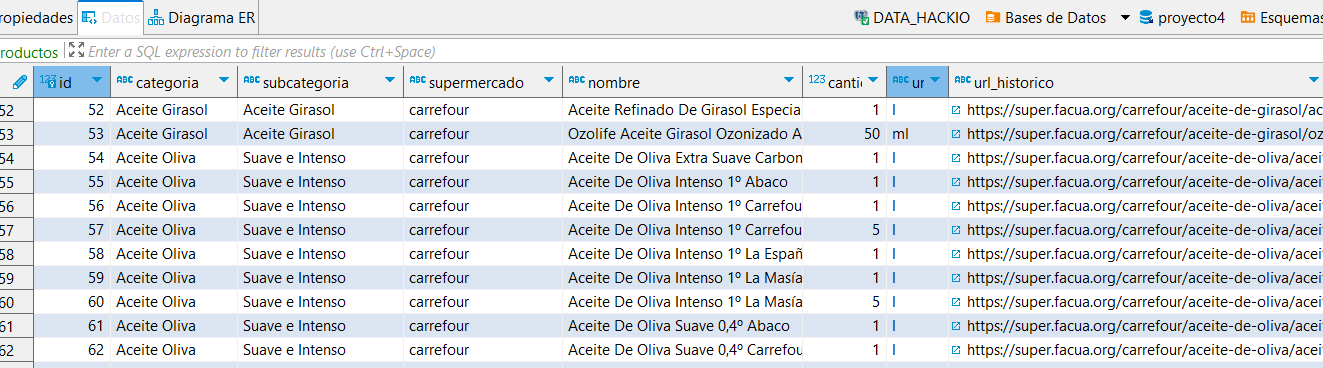

## Historicos
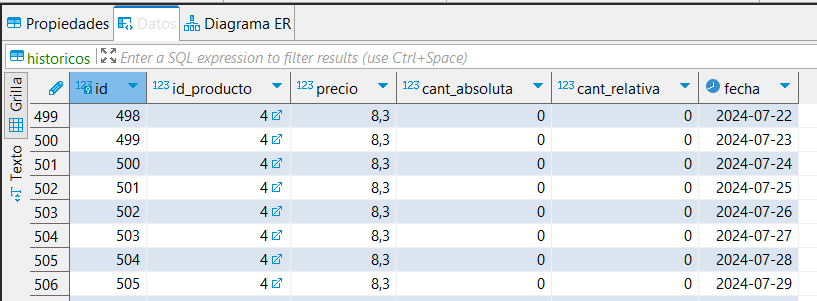